## ИССЛЕДОВАНИЕ ЛОЯЛЬНОСТИ КЛИЕНТОВ К СЕРВИСУ ТЕЛЕКОММУНИКАЦИОННОЙ КОМПАНИИ

### ЭТАПЫ ВЫПОЛНЕНИЯ РАБОТЫ
1. [Загрузка файла с данными](#start)
2. [Цель и задачи исследований](#cond)
3. [Подготовка данных](#analys)  
4. [Анализ данных](#analyse)
5. [Изучение возрастного состава клиентов и его вляние на их лояльность](#seat)
6. [Распределение клиентов по городам проживания и лояльности к сервису](#set)
7. [Связь между "временем жизни" клиента и его лояльностью к сервису](#setl)
8. [Влияние объема потребляемого трафика и типа устройства на отношение клиентов к сервису](#setll)
9. [Выводы](#conc)
10. [Ссылка на дашборд](#dash)
11. [Ссылка на презентацию](#present)

<div class="alert alert-info">
  <b> ЗАГРУЗКА ТАБЛИЦЫ С ДАННЫМИ </b>
    <a id="start"></a> 
</div>

In [ ]:
import os
import pandas as pd
from urllib.parse import urlencode
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/B94szSulN9RLNw' 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
download_response = requests.get(download_url) 
df = pd.read_csv(download_url)

In [45]:
df[:5]

,user_id,lt_day,age,gender_segment,os_name,cpe_type_name,country,city,age_min,age_max,traffic_min,traffic_max,life_min,life_max,nps_score,applience_type,nps_group,gender
0,A001A2,2320,45.0,1.0,ANDROID,SMARTPHONE,Россия,Уфа,45.0,54.0,1.0,5.0,36.0,NaN,10,SMARTPHONE,promoters,female
1,A001WF,2344,53.0,0.0,ANDROID,SMARTPHONE,Россия,Киров,45.0,54.0,1.0,5.0,36.0,NaN,10,SMARTPHONE,promoters,male
2,A003Q7,467,57.0,0.0,ANDROID,SMARTPHONE,Россия,Москва,55.0,64.0,20.0,25.0,13.0,24.0,10,SMARTPHONE,promoters,male
3,A004TB,4190,44.0,1.0,IOS,SMARTPHONE,Россия,РостовнаДону,35.0,44.0,0.1,1.0,36.0,NaN,10,SMARTPHONE,promoters,female
4,A004XT,1163,24.0,0.0,ANDROID,SMARTPHONE,Россия,Рязань,16.0,24.0,5.0,10.0,36.0,NaN,10,SMARTPHONE,promoters,male


<div class="alert alert-info">
  <b> ЦЕЛЬ И ЗАДАЧИ ИССЛЕДОВАНИЙ </b>
    <a id="cond"></a> 
</div>
  Задачей исследования является выявление основных закономерностей в предоставленных данных, связанных с лояльностью клиентов
к сервису компании, оцениваемой по разнице процентных долей сторонников и критиков компании (MPS). Среди основных факторов,
влияющих на величину NPS, можно выделить следующие категории: возраст и пол клиентов, город проживания клиента, 'время жизни'
клиента, тип мобильного устройства и объем потребляемого клиентом трафика. Целью исследования является выявление основных признаков
лояльности клиента, а также установление связи категориальной принадлежности клиента со степенью его лояльности к сервису.   

<div class="alert alert-info">
  <b> ПОДГОТОВКА ДАННЫХ </b>
    <a id="analys"></a> 
</div>

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502493 entries, 0 to 502492
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         502493 non-null  object 
 1   lt_day          502493 non-null  int64  
 2   age             501939 non-null  float64
 3   gender_segment  501192 non-null  float64
 4   os_name         502493 non-null  object 
 5   cpe_type_name   502493 non-null  object 
 6   country         502493 non-null  object 
 7   city            502493 non-null  object 
 8   age_min         501254 non-null  float64
 9   age_max         488703 non-null  float64
 10  traffic_min     502493 non-null  float64
 11  traffic_max     491388 non-null  float64
 12  life_min        502493 non-null  float64
 13  life_max        228194 non-null  float64
 14  nps_score       502493 non-null  int64  
 15  applience_type  502493 non-null  object 
 16  nps_group       502493 non-null  object 
 17  gender    

In [47]:
df['age'].isna().sum()

554

In [48]:
d = []
for i in ['age_min','age_max', 'traffic_max', 'life_max']:
    d.append(df[i].isna().sum())
d

[1239, 13790, 11105, 274299]

<div class="alert alert-info">
  Таблица содержит 17 столбцов и 502493 строки. Изучение типов данных в столбцах показывает, что все все данные имеют верный тип.
Некоторые столбцы имеют пропуски: столбец 'age' - 554 пропуска (заполнить не можем, но число этих пропусков незначительно); 
столбец 'gender_segment' - создан новый столбец типа 'object', в котором пропуски заполнены категорией 'another'; столбец
'age_min' имеет 1239 пропусков, что незначительно по отношению к объему данных; столбцы 'age_max', 'traffic_max', 'life_max' имеют 
более статистически значимые количества пропусков - 13790, 11105 и 274299, соответственно, которые необходимо заполнить значениям
максимальных границ параметров. 
</div>

In [49]:
for i in df['age_max'].unique():
    df.loc[(df['age_max'] == i) & (df['age_min'].isna()), 'age_min'] = df.loc[df['age_max'] == i, 'age_min'].mean()

In [50]:
for i in df['age_min'].unique():
    df.loc[(df['age_min'] == i) & (df['age_max'].isna()), 'age_max'] = df.loc[df['age_min'] == i, 'age_max'].mean()

In [51]:
for i in df['traffic_min'].unique():
    df.loc[(df['traffic_min'] == i) & (df['traffic_max'].isna()), 'traffic_max'] = df.loc[df['traffic_min'] == i, 'traffic_max'].mean()

In [52]:
for i in df['life_min'].unique():
    df.loc[(df['life_min'] == i) & (df['life_max'].isna()), 'life_max'] = df.loc[df['life_min'] == i, 'life_max'].mean()

In [53]:
df.isna().sum()

user_id                0
lt_day                 0
age                  554
gender_segment      1301
os_name                0
cpe_type_name          0
country                0
city                   0
age_min             1239
age_max            13790
traffic_min            0
traffic_max        11105
life_min               0
life_max          274299
nps_score              0
applience_type         0
nps_group              0
gender                 0
dtype: int64

In [54]:
df.duplicated().sum()

0

<div class="alert alert-info">
  После попытки заполнить пропуски их число не изменилось, что говорит о том, что пропучщены только ограничивающие значения 
столбцов 'age_min', 'age_max', 'traffic_max' и 'life_max', которые не имеют реальных значений. Например, интервал возраста
'>65' характеризуется нижней границей '65' и не имеет верхней, которая, соответственно, считывается, как пропуск. Поэтому
при построении диаграмм необходимо использовать нижние границы интервалов, не имеющие пропусков. 
  Дубликатов в извлесенных данных не выявлено.
</div>

<div class="alert alert-info">
  <b> АНАЛИЗ ДАННЫХ </b>
    <a id="analyse"></a> 
</div>

<div class="alert alert-info">
  <b> Изучение возрастного состава клиентов и его вляние на их лояльность </b>
    <a id="seat"></a> 
</div>

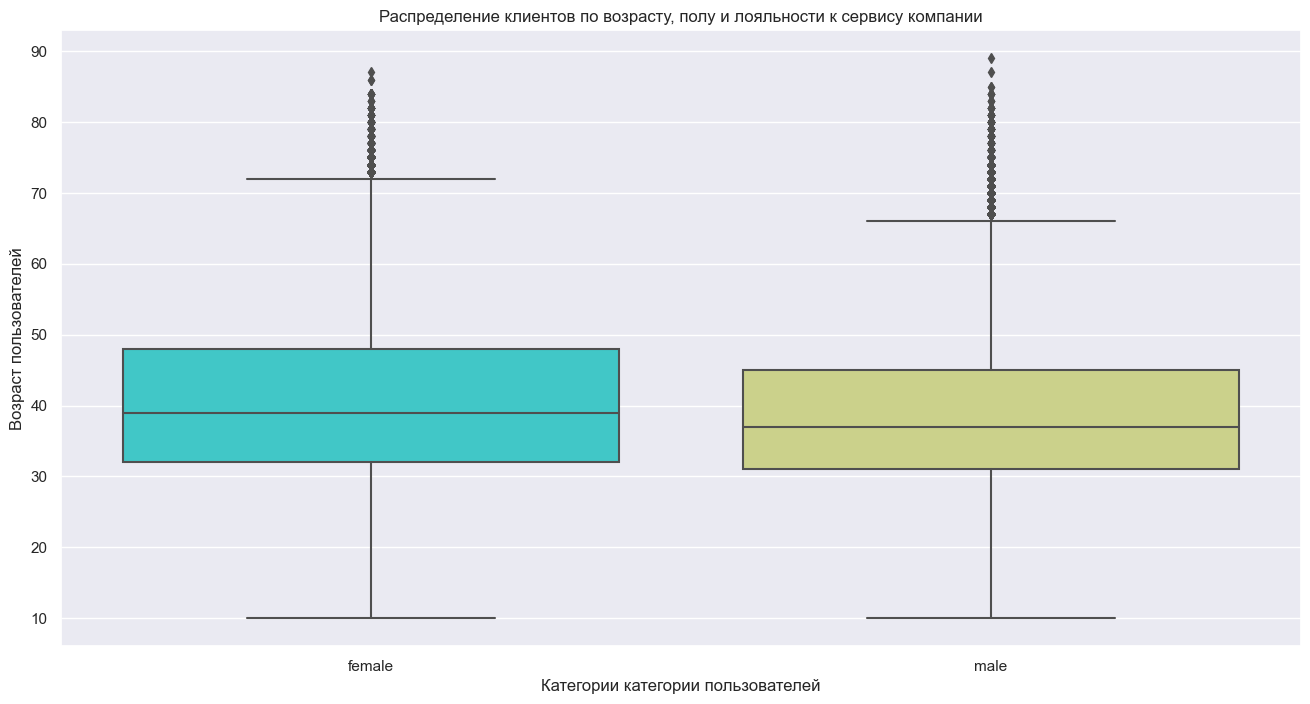

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('bright')
df_n = df.query('gender == "male" or gender == "female"')
sns.set(rc={'figure.figsize':(16,8)})
ax = sns.boxplot(x = 'gender', y = 'age', data = df_n, palette = 'rainbow')
ax.set (xlabel='Категории категории пользователей',
        ylabel='Возраст пользователей',
        title='Распределение клиентов по возрасту, полу и лояльности к сервису компании');

In [56]:
df.loc[df['gender']=='male', 'user_id'].count()

228750

In [57]:
df.loc[df['gender']=='female', 'user_id'].count()

272442

<div class="alert alert-info">
  В опросе принимало участие 272442 женщины и 228750 мужчин. Медианный возраст женщин порядка 39 лет, а мужчин - 37 лет.   
</div>

In [58]:
df_m = df.pivot_table(index = 'nps_group', values = 'user_id', aggfunc = 'count')
df_m['nps'] = (df_m['user_id']['promoters'] - df_m['user_id']['detractors'])*100/(df_m['user_id'].sum())


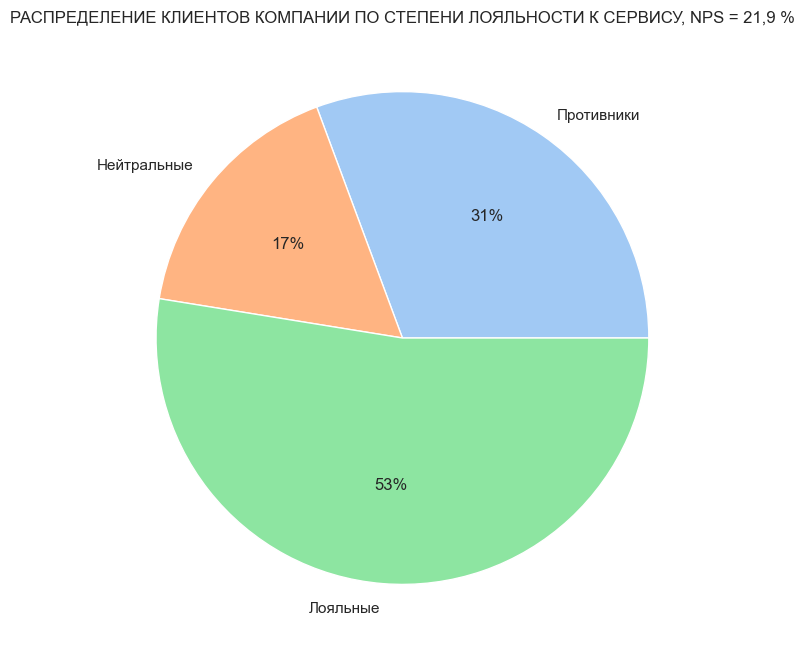

In [59]:
sns.set_style('whitegrid')
sns.set_palette('bright')
sns.set(rc={'figure.figsize':(16,8)})
colors = sns.color_palette('pastel')[ 0:3 ]
labels = ['Противники', 'Нейтральные', 'Лояльные']
plt.pie(list(df_m['user_id']), labels = labels, colors = colors, autopct='%.0f%%')
plt.title('РАСПРЕДЕЛЕНИЕ КЛИЕНТОВ КОМПАНИИ ПО СТЕПЕНИ ЛОЯЛЬНОСТИ К СЕРВИСУ, NPS = 21,9 %')
plt.show()

<div class="alert alert-info">
  Общая выборка всех клиентов комипании показывает, что сторонники сервиса преобладают (53 %). Меньше всего клиентов нейтральных
к севису (17 %). Результирующая величина NPS составляет 21,9 %. 
</div>

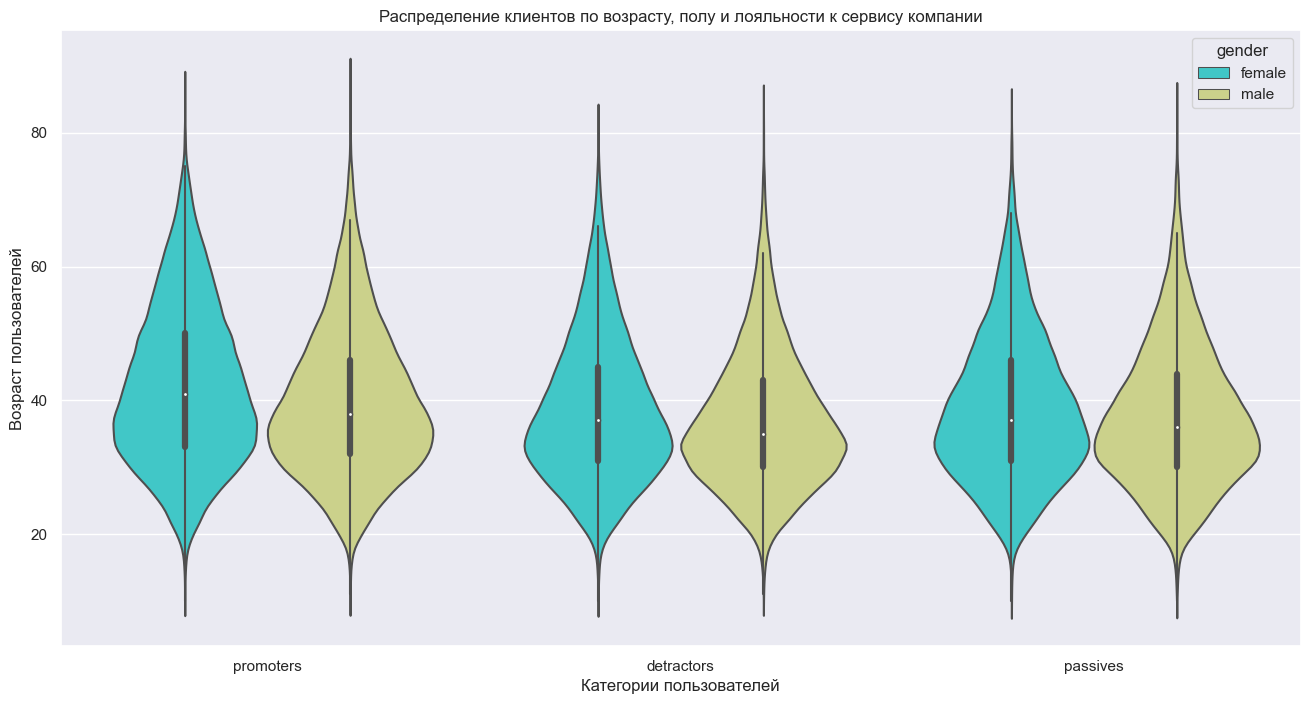

In [60]:
sns.set_style('whitegrid')
sns.set_palette('bright')
sns.set(rc={'figure.figsize':(16,8)})
df_n = df.query('gender == "male" or gender == "female"')
ax = sns.violinplot(x = 'nps_group', y = 'age', data = df_n, palette = 'rainbow', hue = 'gender')
ax.set (xlabel='Категории пользователей',
        ylabel='Возраст пользователей',
        title='Распределение клиентов по возрасту, полу и лояльности к сервису компании');

<div class="alert alert-info">
  Лояльные клиенты имеют, в целом, более высокий медианный возраст, чем противники сервиса и нейтральные клиенты. Медианный
возраст сторонников-мужчин чуть более 40 лет, а женщин - немного ниже 40 лет. Медианный возраст мужчин-противников немного выше 35 лет,
а женщин-противников - около 35 лет. Женская и мужская группы сторонников имеют более значимые, по сравнению с другими группами,
выбросы в сторону 85 - 90 лет.
</div>

In [61]:
import plotly.express as px
df_n = df.groupby(['age_min', 'nps_group'], as_index = False).agg({'user_id':'count'}).sort_values(by = 'user_id', ascending = False)
fig = px.bar(df_n, x = 'age_min', y = 'user_id', color = 'nps_group', height = 500)
fig.update_layout(xaxis_title = 'Возраст клиентов', yaxis_title = 'Число клиентов', 
                  title = 'Зависимость лояльности клиентов к сервису компании от их возрастной группы')
fig.update_traces(textfont_size=12, textangle=10, textposition="inside", cliponaxis=False)
fig.update_traces(textfont_size=12, textangle=10, textposition="inside", cliponaxis=False)
fig.update_layout(
    legend=dict(orientation = "h", title = 'Категории лояльности',
       
        x=0.1, 
        y=1,
        title_font_family="Times New Roman",
        font=dict(
            family="Courier",
            size=12,
            color="black"
        ),
        bgcolor="LightBlue",
        bordercolor="White",
        borderwidth=3
    )
)
fig.show()

<div class="alert alert-info">
  Большинство клиентов компании находятся в возрасте от 20 до 50 лет (больше всего клиентов от 30 до 40 лет. В средних возрастных
группах (20 - 30 лет, 30 - 40 лет) самое большое количество критиков сервиса, хотя их в 1,5 раза и меньше, чем сторонников.
При переходе к более старшим возрастным группам (40 - 50 лет, 50 - 60 лет и старше 60 лет) доля критиков сервиса существенно 
снижается. В молодой группе менее 20 лет количества сторонников и критиков сервиса примерно равны.              

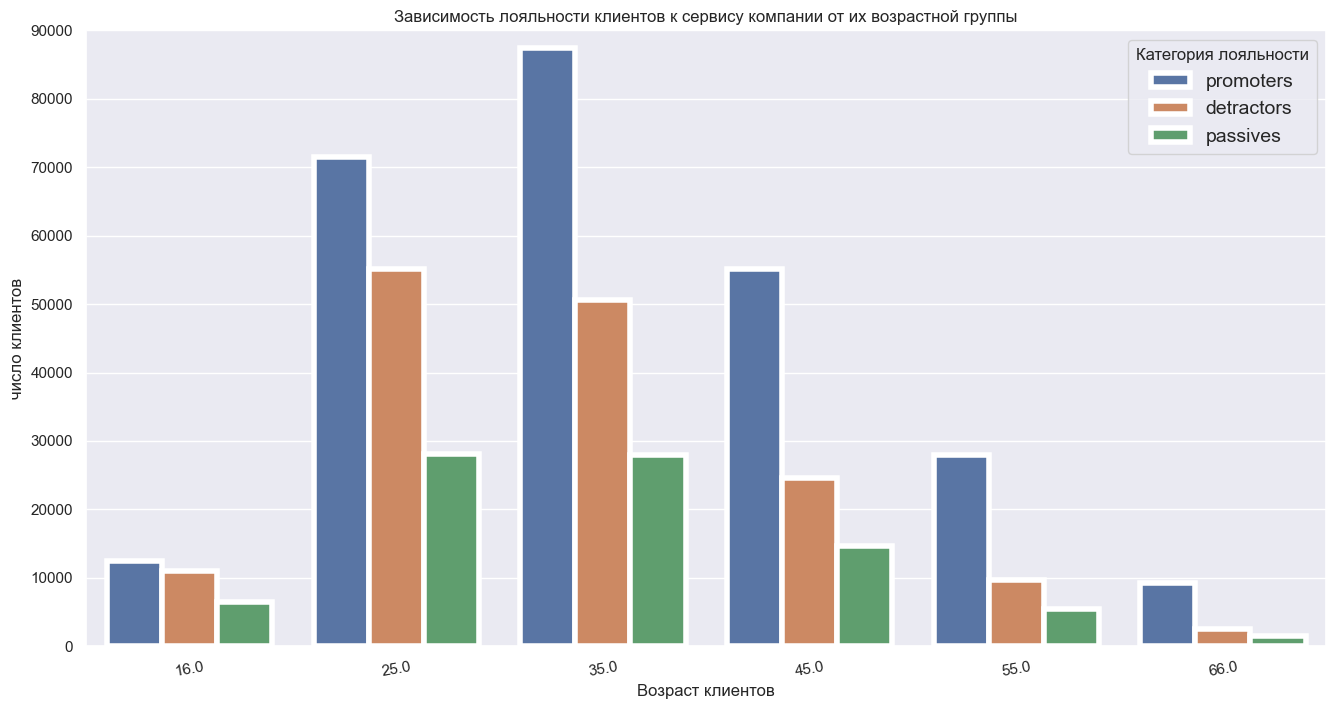

In [62]:
ax = sns.barplot(x = 'age_min', y = 'user_id', data = df_n, hue = 'nps_group', linewidth = 4)
sns.set(rc={'figure.figsize':(16,8)})
ax.set (xlabel='Возраст клиентов', ylim = (0,90000),
        ylabel='число клиентов',
        title='Зависимость лояльности клиентов к сервису компании от их возрастной группы')
plt.legend(loc = 'upper right', title = 'Категория лояльности', fontsize = 14)
plt.xticks(rotation = 10)
plt.show()

<div class="alert alert-info">
  <b> Распределение клиентов по городам проживания и лояльности к сервису </b>
    <a id="set"></a> 
</div>

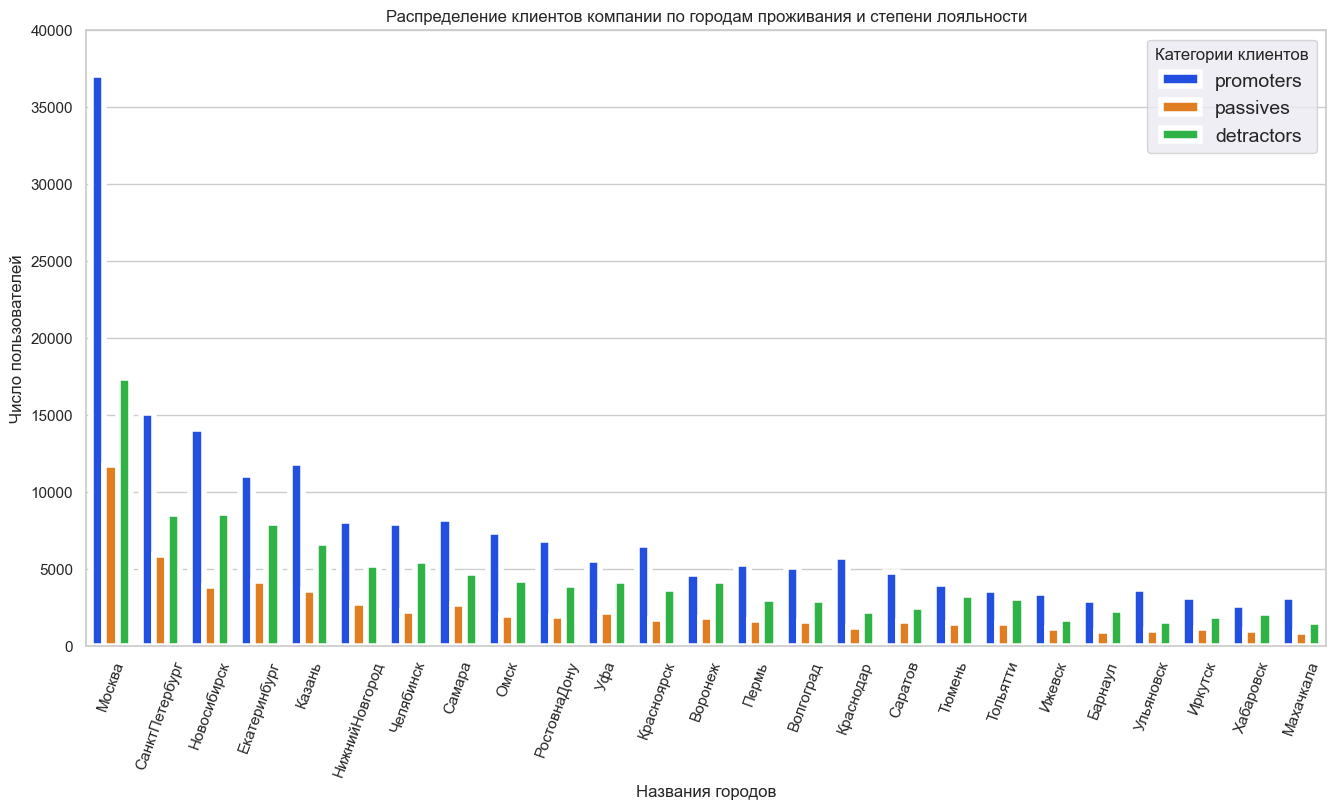

In [63]:
sns.set_style('whitegrid')
sns.set_palette('bright')
df_p = df.groupby(['city','nps_group'], as_index = False).agg({'user_id':'count'})
df_p['total'] = df['user_id']
for i in df_p['city'].unique():
    df_p.loc[df_p['city'] == i, 'total'] = df_p.loc[df_p['city'] == i, 'user_id'].sum() 
df_p = df_p.sort_values(by = 'total', ascending = False)[:75]
ax = sns.barplot(x = 'city', y = 'user_id', data = df_p, hue = 'nps_group', linewidth = 4)
sns.set(rc={'figure.figsize':(16,8)})
ax.set (xlabel='Названия городов', ylim = (0,40000),
        ylabel='Число пользователей',
        title='Распределение клиентов компании по городам проживания и степени лояльности')
plt.legend(loc = 'upper right', title = 'Категории клиентов', fontsize = 14)
plt.xticks(rotation = 70)
plt.show()

<div class="alert alert-info">
  В то-5 городов по числу клиентов компании входят Москва, Петербург, Новосибирск, Екатеринбург и Казань, что примерно коррелирует
с распределением этих кородов по общему количеству населения. В Москве сторонников сервиса примерно в 2 раза больше, чем противников,
а в остальных городах это соотношение заметно меньше: 1,5 - 1,8 раз.   
</div>

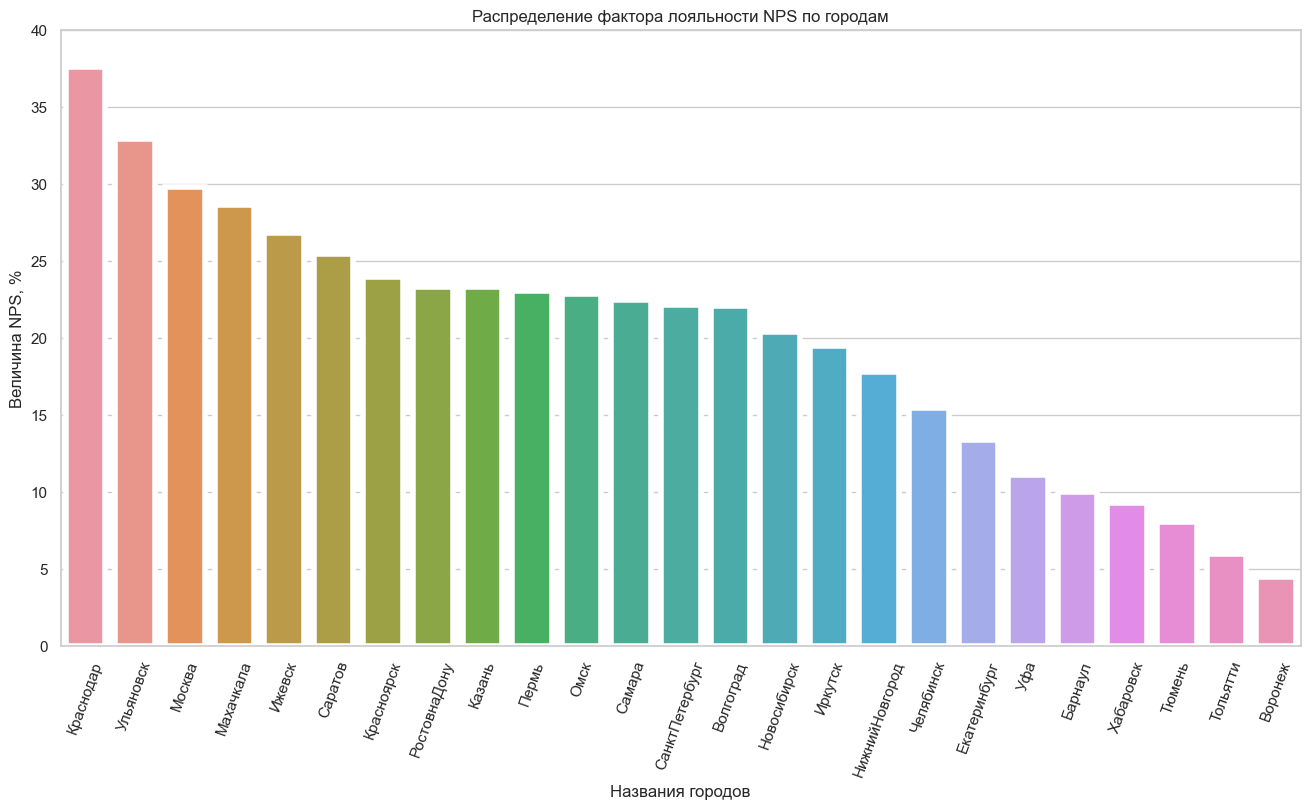

In [64]:
sns.set_style('whitegrid')
sns.set_palette('bright')
df_p = df.groupby(['city','nps_group'], as_index = False).agg({'user_id':'count'})
df_p['total'] = df['user_id']
for i in df_p['city'].unique():
    df_p.loc[df_p['city'] == i, 'total'] = df_p.loc[df_p['city'] == i, 'user_id'].sum() 
df_p = df_p.sort_values(by = 'total', ascending = False)[:75]
df_p['nps'] = df_p['user_id']
for i in df['city'].unique():
    df_p.loc[(df_p['city'] == i), 'nps'] = (df_p.loc[(df_p['city'] == i) & (df_p['nps_group'] == 'promoters'), 'user_id'].mean() - 
                                            df_p.loc[(df_p['city'] == i) & (df_p['nps_group'] == 'detractors'), 'user_id'].mean())*100/df_p.loc[(df_p['city'] == i), 'total'] 
df_p = df_p.sort_values(by = 'nps', ascending = False)
ax = sns.barplot(x = 'city', y = 'nps', data = df_p, linewidth = 4)
sns.set(rc={'figure.figsize':(16,8)})
ax.set (xlabel='Названия городов', ylim = (0,40),
        ylabel='Величина NPS, %',
        title='Распределение фактора лояльности NPS по городам')
#plt.legend(loc = 'upper right', title = 'Категории клиентов', fontsize = 14)
plt.xticks(rotation = 70)
plt.show()

<div class="alert alert-info">
  По величине фактора лояльности NPS в топ-5 городов входят Краснодар, Ульяновск, Москва, Махачкала и Ижевск.
</div>

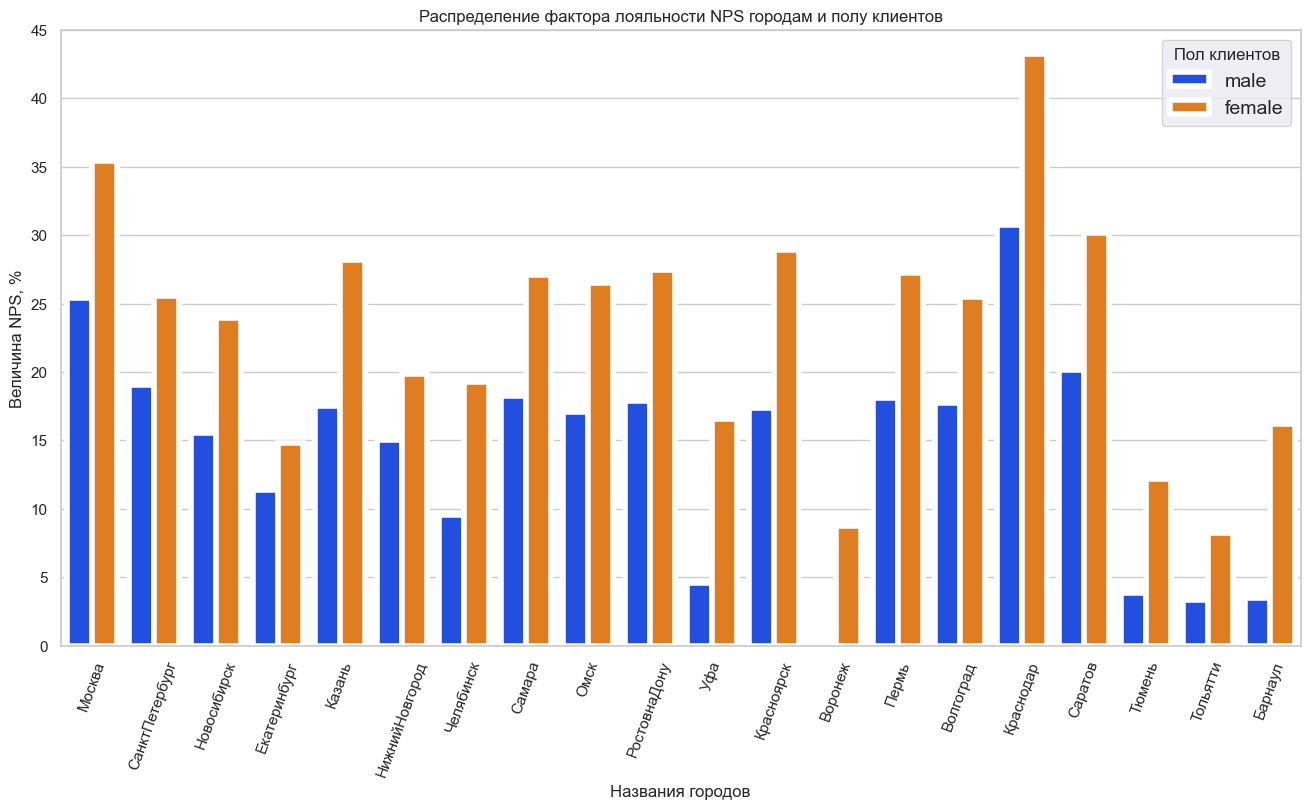

In [65]:
sns.set_style('whitegrid')
sns.set_palette('bright')
df_p = df.groupby(['city', 'gender','nps_group'], as_index = False).agg({'user_id':'count'})
df_p = df_p.query('gender == "male" or gender == "female"')
df_p['total'] = df_p['user_id']
for i in df_p['city'].unique():
    for j in df_p['gender'].unique():
        df_p.loc[(df_p['city'] == i) & (df_p['gender'] == j), 'total'] = df_p.loc[(df_p['city'] == i) & (df_p['gender'] == j), 'user_id'].sum() 
df_p = df_p.sort_values(by = 'total', ascending = False)[:150]
df_p['nps'] = df_p['user_id']
for i in df['city'].unique():
    df_p.loc[(df_p['city'] == i) & (df_p['gender'] == 'male'), 'nps'] = (df_p.loc[(df_p['city'] == i) & (df_p['gender'] == 'male') & (df_p['nps_group'] == 'promoters'), 'user_id'].sum() - 
                                            df_p.loc[(df_p['city'] == i) & (df_p['gender'] == 'male') & (df_p['nps_group'] == 'detractors'), 'user_id'].sum())*100/df_p.loc[(df_p['city'] == i) & (df_p['gender'] == 'male'), 'total'].mean() 
for i in df['city'].unique():
    df_p.loc[(df_p['city'] == i) & (df_p['gender'] == 'female'), 'nps'] = (df_p.loc[(df_p['city'] == i) & (df_p['gender'] == 'female') & (df_p['nps_group'] == 'promoters'), 'user_id'].sum() - 
                                            df_p.loc[(df_p['city'] == i) & (df_p['gender'] == 'female') & (df_p['nps_group'] == 'detractors'), 'user_id'].sum())*100/df_p.loc[(df_p['city'] == i) & (df_p['gender'] == 'female'), 'total'].mean() 
df_p['Total'] = df_p['total']
for i in df_p['city'].unique():
    df_p.loc[df_p['city'] == i, 'Total'] = df_p.loc[df_p['city'] == i, 'user_id'].sum()
df_p = df_p.sort_values(by = 'Total', ascending = False)[:120]
ax = sns.barplot(x = 'city', y = 'nps', data = df_p, hue = 'gender', linewidth = 4)
sns.set(rc={'figure.figsize':(16,8)})
ax.set (xlabel='Названия городов', ylim = (0,45),
        ylabel='Величина NPS, %',
        title='Распределение фактора лояльности NPS городам и полу клиентов')
plt.legend(loc = 'upper right', title = 'Пол клиентов', fontsize = 14)
plt.xticks(rotation = 70)
plt.show()

In [66]:
df_p['nps'].corr(df_p['Total'])

0.31069845757705405

<div class="alert alert-info">
  Между величиной рейтинга NPS и численностью клиентов компании в данном городе существует слабая прямопропорциональная
связь (коэф корреляции 0,31). Женщины во всех городах в 1,5 - 2 раза более лояльны к сервису, чем мужчины.
</div>

<div class="alert alert-info">
  <b> Связь между "временем жизни" клиента и его лояльностью к сервису </b>
    <a id="setl"></a> 
</div>

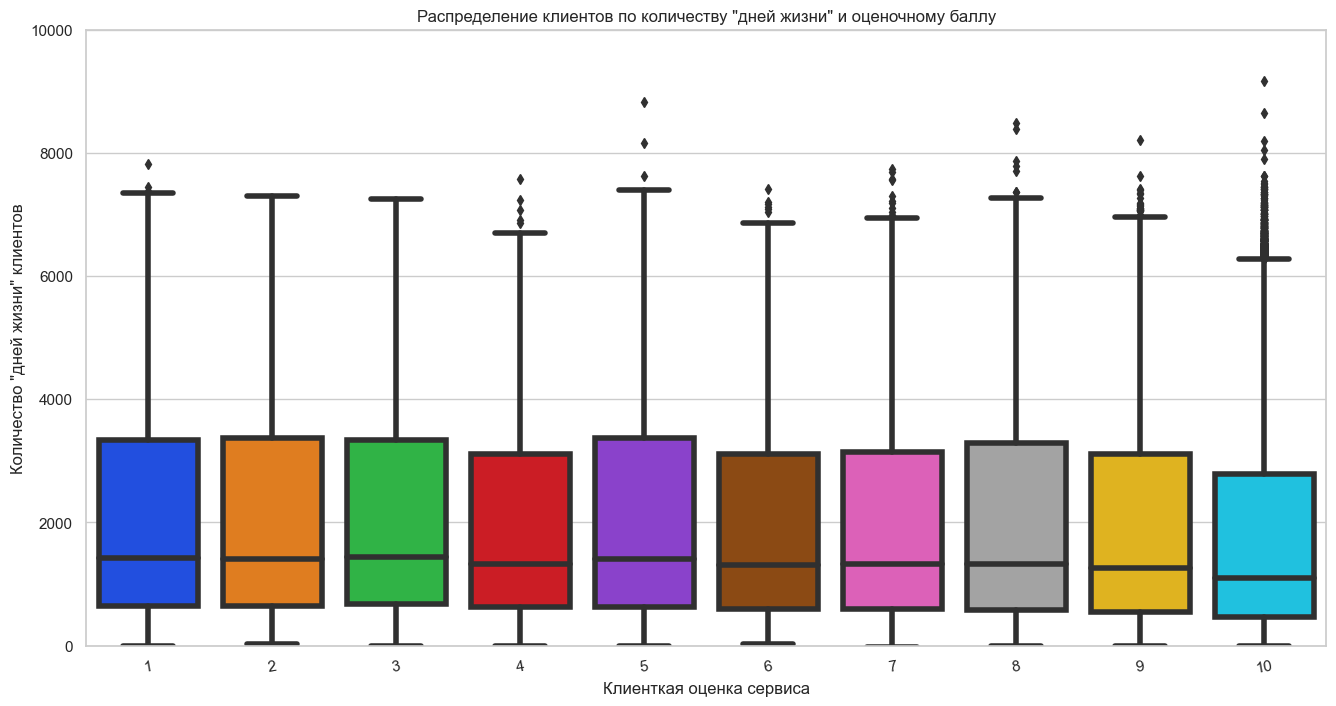

In [67]:
sns.set_style('whitegrid')
sns.set_palette('bright')
ax = sns.boxplot(x = 'nps_score', y = 'lt_day', data = df, linewidth = 4)
sns.set(rc={'figure.figsize':(16,8)})
ax.set (xlabel='Клиенткая оценка сервиса', ylim = (0,10000),
        ylabel='Количество "дней жизни" клиентов',
        title='Распределение клиентов по количеству "дней жизни" и оценочному баллу')  

plt.xticks(rotation = 10)
plt.show()

<div class="alert alert-info">
  Медианное 'время жизни' клиента последовательно снижается с повышением оценочного балла сервиса. То есть, 'свежие' клиенты
более лояльны к сервису, по сравнению с давними клиентами компании.
</div>

In [68]:
df_n = df.groupby(['life_min', 'nps_group'], as_index = False).agg({'user_id':'count'}).sort_values(by = 'user_id', ascending = False)
def f(g):
    if g == 1:
        return '1 - 2'
    elif g == 2:
        return '2 - 3'
    elif g == 3:
        return '3 - 4'
    elif g == 4:
        return '4 - 7'
    elif g == 7:
        return '7 - 13'
    elif g == 13:
        return '13 - 25'
    elif g == 25:
        return '25 - 36'
df_n['rank'] = df_n['life_min'].apply(f)
fig = px.bar(df_n, x = 'rank', y = 'user_id', color = 'nps_group', height = 500)
fig.update_layout(xaxis_title = '"Время жизни" клиентов, мес.', yaxis_title = 'Число клиентов', 
                  title = 'Зависимость лояльности клиентов к сервису компании от их "времени жизни"')
fig.update_traces(textfont_size=12, textangle=10, textposition="inside", cliponaxis=False)
fig.update_layout(yaxis_range=[0,100000])
fig.update_layout(
    legend=dict(orientation = "h", title = 'Категории лояльности',
       
        x=0.1, 
        y=1,
        title_font_family="Times New Roman",
        font=dict(
            family="Courier",
            size=12,
            color="black"
        ),
        bgcolor="LightBlue",
        bordercolor="White",
        borderwidth=3
    )
)
fig.show()

<div class="alert alert-info">
  Наиболее многочисленна гркппа клиентов со 'временем жизни' 13 - 25 мес., которая на 25 % больше второй по численности группы
25 - 36 мес. При дальнейшем снижении 'времени жизни' клиентов от 13 до 1 мес. их численность сильно снижается до исчезающе
малого значения для наиболее свежих клиентов со сроком 1 - 2 мес. При этом, уменьшение 'времени жизни' сопровождается снижением
как количества критиков сервиса, так и его доли по отношению к лояльным клиентам. 
</div>

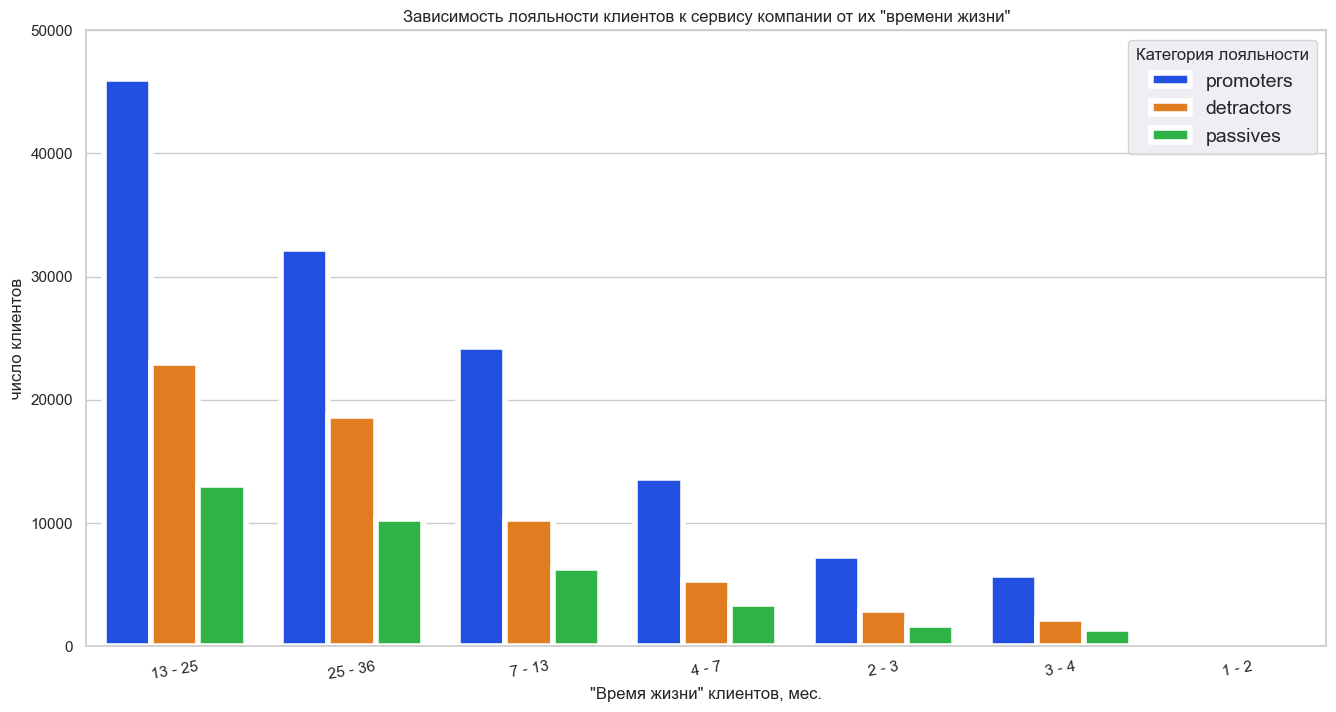

In [69]:
sns.set_style('whitegrid')
sns.set_palette('bright')
ax = sns.barplot(x = 'rank', y = 'user_id', data = df_n, hue = 'nps_group', linewidth = 4)
sns.set(rc={'figure.figsize':(16,8)})
ax.set (xlabel='"Время жизни" клиентов, мес.', ylim = (0,50000),
        ylabel='число клиентов',
        title='Зависимость лояльности клиентов к сервису компании от их "времени жизни"')
plt.legend(loc = 'upper right', title = 'Категория лояльности', fontsize = 14)
plt.xticks(rotation = 10)
plt.show()

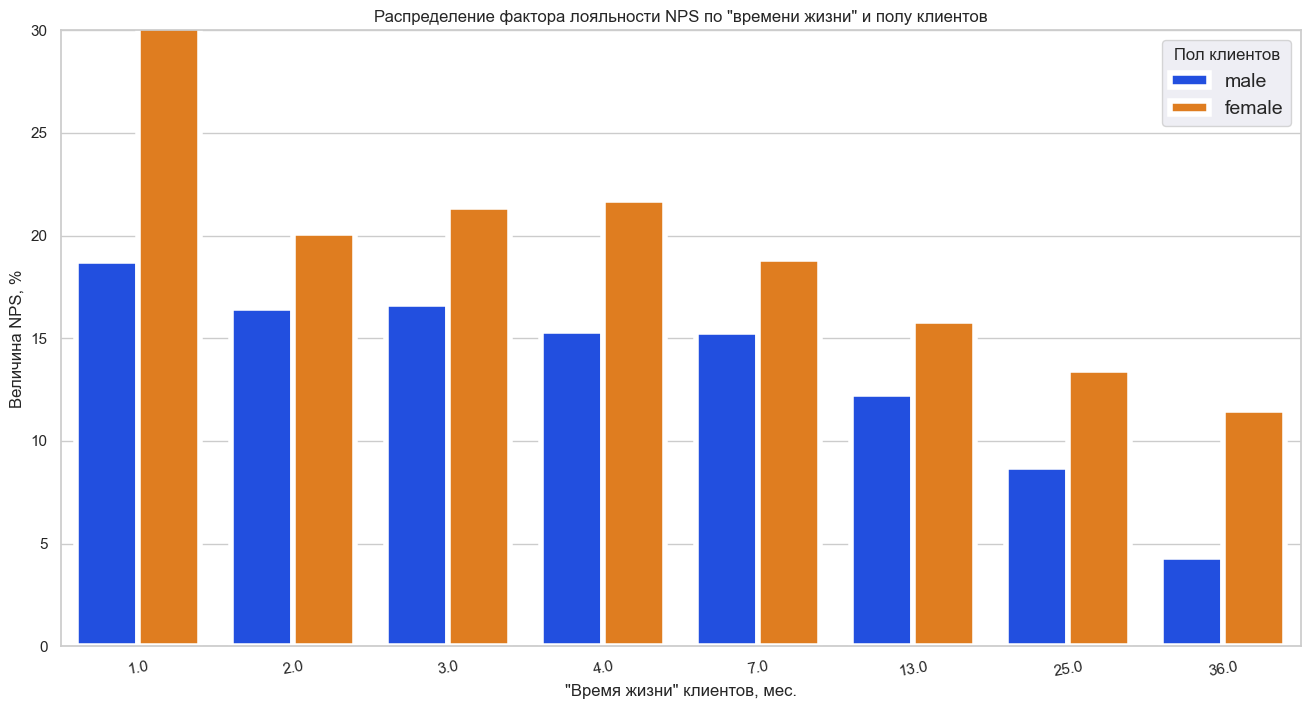

In [41]:
sns.set_style('whitegrid')
sns.set_palette('bright')
df_p = df.groupby(['life_min', 'gender','nps_group'], as_index = False).agg({'user_id':'count'})
df_p = df_p.query('gender == "male" or gender == "female"')
df_p['total'] = df_p['user_id']
for i in df_p['life_min'].unique():
    df_p.loc[df_p['life_min'] == i, 'total'] = df_p.loc[df_p['life_min'] == i, 'user_id'].sum() 
df_p = df_p.sort_values(by = 'total', ascending = False)[:150]
df_p['nps'] = df_p['user_id']
for i in df_p['life_min'].unique():
    df_p.loc[(df_p['life_min'] == i) & (df_p['gender'] == 'male'), 'nps'] = (df_p.loc[(df_p['life_min'] == i) & (df_p['gender'] == 'male') & (df_p['nps_group'] == 'promoters'), 'user_id'].sum() - 
                                            df_p.loc[(df_p['life_min'] == i) & (df_p['gender'] == 'male') & (df_p['nps_group'] == 'detractors'), 'user_id'].sum())*100/df_p.loc[(df_p['life_min'] == i), 'total'].mean() 
for i in df['life_min'].unique():
    df_p.loc[(df_p['life_min'] == i) & (df_p['gender'] == 'female'), 'nps'] = (df_p.loc[(df_p['life_min'] == i) & (df_p['gender'] == 'female') & (df_p['nps_group'] == 'promoters'), 'user_id'].sum() - 
                                            df_p.loc[(df_p['life_min'] == i) & (df_p['gender'] == 'female') & (df_p['nps_group'] == 'detractors'), 'user_id'].sum())*100/df_p.loc[(df_p['life_min'] == i), 'total'].mean() 

df_p.sort_values(by = 'total', ascending = True)
ax = sns.barplot(x = 'life_min', y = 'nps', data = df_p, hue = 'gender', linewidth = 4)
sns.set(rc={'figure.figsize':(16,8)})
ax.set (xlabel='"Время жизни" клиентов, мес.', ylim = (0,30),
        ylabel='Величина NPS, %',
        title='Распределение фактора лояльности NPS по "времени жизни" и полу клиентов')
plt.legend(loc = 'upper right', title = 'Пол клиентов', fontsize = 14)
plt.xticks(rotation = 10)
plt.show()

<div class="alert alert-info">
  С увеличением 'времени жизни' клиента наблюдается четкая обратная корреляция с о степенью его лояльности к сервису. Чем больше
'срок жизни' тем ниже величина фактора NPS: так у клиентов со 'сроком жизни' 1 - 2 месяца величина NPS составляет порядка 20 %,
а для клиентов с 'сроком жизни' 25 - 36 мес. и более фактор NPS уже не превышает 10 %. То есть, по мере того, как клиенты 
потребляют услуги компании и общаются с ее поддержкой их лояльность к новым сервисам сильно снижается, что свидетельствует
о существенных недоработках менеджмента компании и отсутствии поощрительных программ лояльности. Во всех рассмотренных категориях
женщины, в среднем, в 1,5 - 2 раза лояльнее мужчин.
</div>

<div class="alert alert-info">
  <b> Влияние объема потребляемого трафика и типа устройства на отношение клиентов к сервису </b>
    <a id="setll"></a> 
</div>

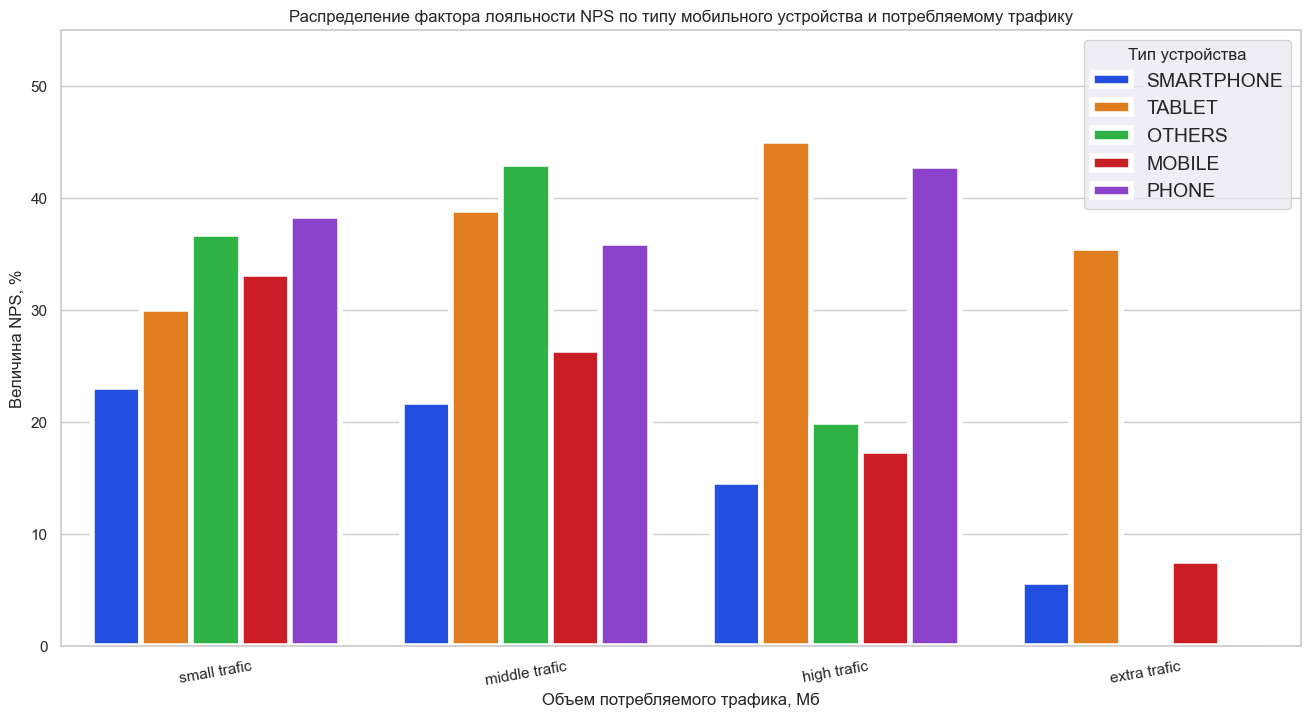

In [70]:
sns.set_style('whitegrid')
sns.set_palette('bright')
def f(g):
    if g <= 10:
        return 'small trafic'
    elif g > 10 and g <=50:
        return 'middle trafic'
    elif g > 50 and g <= 75:
        return 'high trafic'
    else:
        return 'extra trafic'
df['traffic_gr'] = df['traffic_min'].apply(f)
df_p = df.groupby(['traffic_gr', 'applience_type', 'nps_group'], as_index = False).agg({'user_id':'count'})
df_p['total'] = df_p['user_id']
for i in df_p['traffic_gr'].unique():
    for j in df_p['applience_type'].unique():
        df_p.loc[(df_p['traffic_gr'] == i) & (df_p['applience_type'] == j), 'total'] = df_p.loc[(df_p['traffic_gr'] == i) & (df_p['applience_type'] == j), 'user_id'].sum() 
df_p = df_p.sort_values(by = 'total', ascending = False)[:150]
df_p['nps'] = df_p['user_id']
for i in df_p['traffic_gr'].unique():
    for j in df_p['applience_type']:
        df_p.loc[(df_p['traffic_gr'] == i) & (df_p['applience_type'] == j), 'nps'] = (df_p.loc[(df_p['traffic_gr'] == i) & (df_p['applience_type'] == j) & (df_p['nps_group'] == 'promoters'), 'user_id'].sum() - 
                                            df_p.loc[(df_p['traffic_gr'] == i) & (df_p['applience_type'] == j) & (df_p['nps_group'] == 'detractors'), 'user_id'].sum())*100/df_p.loc[(df_p['traffic_gr'] == i) & (df_p['applience_type'] == j), 'total'].mean() 

df_p['Total'] = df_p['total']
for i in df_p['traffic_gr'].unique():
    df_p.loc[df_p['traffic_gr'] == i, 'Total'] = df_p.loc[df_p['traffic_gr'] == i, 'user_id'].sum()
df_p = df_p.sort_values(by = 'Total', ascending = False)
#df_p.loc[df_p['applience_type'] == 'SMARTPHONE', 'nps'] = df_p.loc[df_p['applience_type'] == 'SMARTPHONE', 'nps']/15
ax = sns.barplot(x = 'traffic_gr', y = 'nps', data = df_p, hue = 'applience_type', linewidth = 4)
sns.set(rc={'figure.figsize':(16,8)})
ax.set (xlabel='Объем потребляемого трафика, Мб', ylim = (0,55),
        ylabel='Величина NPS, %',
        title='Распределение фактора лояльности NPS по типу мобильного устройства и потребляемому трафику')
plt.legend(loc = 'upper right', title = 'Тип устройства', fontsize = 14)
plt.xticks(rotation = 10)
plt.show()

In [71]:
df_p['nps'].corr(df_p['Total'])

0.4530963488212727

<div class="alert alert-info">
    В среднем, с увеличением объема потребляемого трафика лояльность пользователей снижается. Наиболее многочисленные категории
клиентов потребляет небольшой (менее 10 Мб) или средний (10 - 50 Мб) трафик и имеют наибольшую среднюю величину NPS. 
    Среди пользователей гаджетов наибольшей лояльностью отличаются владельцы устройств типа TABLET и PHONE, их лояльность, в целом,
не изменяется с ростом потребляемого трафика. Фактор NPS для пользователей устройств SMARTPHONE и NOBILE последовательно понижается
с увеличением потребляемого трафика. Наиболее важное значение имеет динамика лояльности для владельцев SMARTPHONE, так как их доля
составляет более 95 % от всего количества клиентов. 
</div>

<div class="alert alert-info">
    <b> ВЫВОДЫ </b>
  <a id="conc"></a>
    
  <b> Предобработка данных </b>
    Таблица содержит 17 столбцов и 502493 строки. Изучение типов данных в столбцах показывает, что все все данные имеют верный тип.
Некоторые столбцы имеют пропуски: столбец 'age' - 554 пропуска (заполнить не можем, но число этих пропусков незначительно); 
столбец 'gender_segment' - создан новый столбец типа 'object', в котором пропуски заполнены категорией 'another'; столбец
'age_min' имеет 1239 пропусков, что незначительно по отношению к объему данных; столбцы 'age_max', 'traffic_max', 'life_max' имеют 
более статистически значимые количества пропусков - 13790, 11105 и 274299, соответственно, которые необходимо заполнить значениям
максимальных границ параметров. 
    После попытки заполнить пропуски их число не изменилось, что говорит о том, что пропучщены только ограничивающие значения 
столбцов 'age_min', 'age_max', 'traffic_max' и 'life_max', которые не имеют реальных значений. Например, интервал возраста
'>65' характеризуется нижней границей '65' и не имеет верхней, которая, соответственно, считывается, как пропуск. Поэтому
при построении диаграмм необходимо использовать нижние границы интервалов, не имеющие пропусков. 
  Дубликатов в извлесенных данных не выявлено.
    
     <b> АНАЛИХ ДАННЫХ </b>
    
   <b> Влияние возраста на лояльность отношения клиентов к сервису </b>
    В опросе принимало участие 272442 женщины и 228750 мужчин. Медианный возраст женщин порядка 39 лет, а мужчин - 37 лет. 
    Общая выборка всех клиентов комипании показывает, что сторонники сервиса преобладают (53 %). Меньше всего клиентов нейтральных
к севису (17 %). Результирующая величина NPS составляет 21,9 %.
    Лояльные клиенты имеют, в целом, более высокий медианный возраст, чем противники сервиса и нейтральные клиенты. Медианный
возраст сторонников-мужчин чуть более 40 лет, а женщин - немного ниже 40 лет. Медианный возраст мужчин-противников немного выше 35 лет,
а женщин-противников - около 35 лет. Женская и мужская группы сторонников имеют более значимые, по сравнению с другими группами,
выбросы в сторону 85 - 90 лет.
    Большинство клиентов компании находятся в возрасте от 20 до 50 лет (больше всего клиентов от 30 до 40 лет. В средних возрастных
группах (20 - 30 лет, 30 - 40 лет) самое большое количество критиков сервиса, хотя их в 1,5 раза и меньше, чем сторонников.
При переходе к более старшим возрастным группам (40 - 50 лет, 50 - 60 лет и старше 60 лет) доля критиков сервиса существенно 
снижается. В молодой группе менее 20 лет количества сторонников и критиков сервиса примерно равны.  

  <b> Распределение городов по степени лояльности клиентов </b>
    В то-5 городов по числу клиентов компании входят Москва, Петербург, Новосибирск, Екатеринбург и Казань, что примерно коррелирует
с распределением этих кородов по общему количеству населения. В Москве сторонников сервиса примерно в 2 раза больше, чем противников,
а в остальных городах это соотношение заметно меньше: 1,5 - 1,8 раз.  
    По величине фактора лояльности NPS в топ-5 городов входят Краснодар, Ульяновск, Москва, Махачкала и Ижевск.
    Между величиной рейтинга NPS и численностью клиентов компании в данном городе существует слабая прямопропиональная
связь (коэф корреляции 0,31). Женщины во всех городах в 1,5 - 2 раза более лояльны к сервису, чем мужчины.
                                                                        
   <b> Влияние 'времени жизни' клиента на лояльность к сервису </b>
    Медианное 'время жизни' клиента последовательно снижается с повышением оценочного балла сервиса. То есть, 'свежие' клиенты
более лояльны к сервису, по сравнению с давними клиентами компании.
    Наиболее многочисленна гркппа клиентов со 'временем жизни' 13 - 25 мес., которая на 25 % больше второй по численности группы
25 - 36 мес. При дальнейшем снижении 'времени жизни' клиентов от 13 до 1 мес. их численность сильно снижается до исчезающе
малого значения для наиболее свежих клиентов со сроком 1 - 2 мес. При этом, уменьшение 'времени жизни' сопровождается снижением
как количества критиков сервиса, так и его доли по отношению к лояльным клиентам. 
    С увеличением 'времени жизни' клиента наблюдается четкая обратная корреляция с о степенью его лояльности к сервису. Чем больше
'срок жизни' тем ниже величина фактора NPS: так у клиентов со 'сроком жизни' 1 - 2 месяца величина NPS составляет порядка 20 %,
а для клиентов с 'сроком жизни' 25 - 36 мес. и более фактор NPS уже не превышает 10 %. То есть, по мере того, как клиенты 
потребляют услуги компании и общаются с ее поддержкой их лояльность к новым сервисам сильно снижается, что свидетельствует
о существенных недоработках менеджмента компании и отсутствии поощрительных программ лояльности. Во всех рассмотренных категориях
женщины, в среднем, в 1,5 - 2 раза лояльнее мужчин.

    <b> Связь между потребляемым трафиком, типом каджета и лояльностью клиента </b>
     В среднем, с увеличением объема потребляемого трафика лояльность пользователей снижается. Наиболее многочисленные категории
клиентов потребляет небольшой (менее 10 Мб) или средний (10 - 50 Мб) трафик и имеют наибольшую среднюю величину NPS. 
    Среди пользователей гаджетов наибольшей лояльностью отличаются владельцы устройств типа TABLET и PHONE, их лояльность, в целом,
не изменяется с ростом потребляемого трафика. Фактор NPS для пользователей устройств SMARTPHONE и NOBILE последовательно понижается
с увеличением потребляемого трафика. Наиболее важное значение имеет динамика лояльности для владельцев SMARTPHONE, так как их доля
составляет более 95 % от всего количества клиентов. 


</div>

<div class="alert alert-info">
<a id="dash"></a>
<b> Ссылка на дашборд: </b> 
https://public.tableau.com/shared/KNPH96GFD?:display_count=n&:origin=viz_share_link

<div class="alert alert-info">
<a id="present"></a>
<b> Ссылка на презентацию:</b> https://disk.yandex.ru/i/XHCqVdCmzsQ8uw